# This project will be a continuation of Project 1 (see attached report and notebook). This time, for all missing values, we will fill with the averages for the columns rather than by performing row-wise elemination. We set the per-test significance level 𝛼 to 0.005 (as per Benjamin et al., 2018). 

### Dataset description

This dataset features ratings data of 400 movies from 1097 research participants. 

* 1st row: Headers (Movie titles/questions) – note that the indexing in this list is from 1
* Row 2-1098: Responses from individual participants
* Columns 1-400: These columns contain the ratings for the 400 movies (0 to 4, and missing)
* Columns 401-421: These columns contain self-assessments on sensation seeking behaviors (1-5)
* Columns 422-464: These columns contain responses to personality questions (1-5)
* Columns 465-474: These columns contain self-reported movie experience ratings (1-5)
* Column 475: Gender identity (1 = female, 2 = male, 3 = self-described)
* Column 476: Only child (1 = yes, 0 = no, -1 = no response)
* Column 477: Movies are best enjoyed alone (1 = yes, 0 = no, -1 = no response)

In [30]:
#!/usr/bin/env python

import importlib
from myModules import movieClass
importlib.reload(movieClass)
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as  plt
from labellines import labelLines

Movies = movieClass.movie(verbose=False, alpha=0.005)

## Taking the maximum absolute value of a correlation coefficient, we answer the following:

1.1. For every user in the given data, we find its most correlated user. 

1.2. We find the pair of the most correlated users in the data using the averaging technique described prior: Users 831 and 896.

1.3. We find that the value of this highest correlation is 0.9995. 

1.4. We print the most correlated user to users 0, 1, 2, ... , 9, respectively. 


In [186]:
usrData = pd.DataFrame(Movies.userData()).T
names = ['User ' + str(i) for i in range(len(usrData.columns))]
usrData.columns = names

corr = usrData.corr().abs()
#keep lower triangular without the diagonal
corr[:] = np.tril(corr.values, k=-1)
corrMax = corr.max()
megaMax = corrMax.max()

pairs = []
i = 0
for usr in names:   
    match = corr.index[corr[usr] == corrMax[i]].tolist()
    pairs.append((usr,*match,'Coefficient of ' + str(corrMax[i])))
    i+=1

corrUsers = []
for i in range(10):
    corrUsers.append(pairs[i][1])
string = "The most correlated users for users 0 to 9 were as follows: {list}.".format(list=corrUsers)
print(string)

for pair in pairs:
    if pair[2] == 'Coefficient of ' + str(megaMax):
        megaPair = (pair[0],pair[1])
        break
string = "The most correlated pair of users is pair {pair} with coefficient of {coeff}.".format(pair=megaPair, coeff=megaMax)
print(string)

The most correlated users for users 0 to 9 were as follows: ['User 583', 'User 831', 'User 896', 'User 364', 'User 896', 'User 99', 'User 239', 'User 896', 'User 896', 'User 1004'].
The most correlated pair of users is pair ('User 831', 'User 896') with coefficient of 0.999542426149521.


## Now, we want to find a model between the ratings and the personal part of the data. To do so, we consider:


 **Independent Variables**: the ratings of all users over columns 1-400: 

 * These columns contain the ratings for the 400 movies (0 to 4, and missing);

We all this part `df_rate`


### and 


 **Dependent Variables**:  the part of the data which includes all users over columns 401-474

 * Columns 401-421: These columns contain self-assessments on sensation seeking behaviors (1-5)
 * Columns 422-464: These columns contain responses to personality questions (1-5)
 * Columns 465-474: These columns contain self-reported movie experience ratings (1-5)

We call this part `df_pers`.

---

## Our main task is to model: 


### `df_pers = function(df_rate)`
---

## To achieve this without concerning ourselves with dimensionality reduction (just yet) we opt to focus on the sensation-seeking beheaviors (Columns 401-421) as they query in such a way that responses lie on a risky/high energy-to-risk averse spectrum. These columns are aggregated to form our dependent vector from which the movie rating weights (for all 400 films) will be our predictors.

For our dependent (aggregated subset of personality results) we model the movie weights as a matrix $\beta$ and our independent variables in a predictor matrix $X$. Factoring in residuals (really, noise) as a vector $\epsilon$ we have the following proposed model: $$Y = X \beta + \epsilon $$

In [187]:
#For missing entries, avg from the column used. Personal columns are from 401 to 474. First 400 are movie ratings.
Movies = movieClass.movie(verbose=False,alpha=0.005,fillAvg=True)
data = Movies.columnData(fillAvg=True, dropNan = False)
df_rate = pd.DataFrame(data[:Movies.movieCols])
df_pers = pd.DataFrame(data[Movies.movieCols:-3])

#80% for training set, 20% for test
#Model df_pers = function(df_rate)
x_train,x_test,y_train,y_test=train_test_split(df_rate.T,df_pers.T,test_size=0.2, random_state = 42)

# We're going to focus particularly on sensation-seeking behaviors (Columns 401-421) as they all query from a set of questions that lie on a risky/high energy-to-risk-averse spectrum 
# and will be aggregated to form our dependent vector  

Y_train = y_train.iloc[:,0:20].agg('sum',axis='columns')# dependent variables (really, y_hat + residuals, y = (B_0 * x_0 +...+ B_76 * x_76) + e for ALL users, so multiple OLS)
Y_test = y_test.iloc[:,0:20].agg('sum',axis='columns')

## OLS Linear Regression Model
**Note:** We split the original data into training and testing as the ratio 0.80: 0.20. 


2.1. Model `df_pers = function(df_rate)` by using the linear regression. 

### What are the errors on: (i) the training part; (ii) the testing part?

To achieve this, we consider the following form of a OLS model (recall bias term at index 0): $$ Y = \sum_{i=1}^{1097} (y_i - \sum_{j=0}^{400} x_{i,j}*\beta\\_j)^2$$

Or, alternatively, $$Y = (XX')^{-1}X'y$$

## To define error, we use the mean absolute error (MAE).

The mean absolute error is defined as: $$ MAE = \dfrac{\sum_{i=1}^{1097} \lvert y_i - Y_i \rvert }{1097}  $$ where $y_i$ is our prediction and $Y_i$ is the true value. All scales of measurement are the same in order to quantify this arithmetic average throughout. Note that this is not the mean absolute deviation. 


In [188]:
# OLS Model
model = linear_model.LinearRegression().fit(x_train, Y_train)  # fitting the model
#Predict function is model.intercept_ + np.dot(x_train, model.coef_)
yhat_test = model.predict(x_test)
yhat_train = model.predict(x_train)

train_MAE_OLS = mean_absolute_error(Y_train.values, yhat_train) 
test_MAE_OLS = mean_absolute_error(Y_test.values, yhat_test)

print('The MAE for the training data using an OLS model is: {mae}'.format(mae=np.round(train_MAE_OLS,4)))
print('The MAE for the test data using an OLS model is: {mae}'.format(mae=np.round(test_MAE_OLS,4)))


The MAE for the training data using an OLS model is: 4.3365
The MAE for the test data using an OLS model is: 10.1137


## Ridge Regression 
2.2. Model `df_pers = function(df_rate)` by using the ridge regression with hyperparamter values alpha from [0.0, 1e-8, 1e-5, 0.1, 1, 10]. 

To achieve this, we consider the following form of a ridge regression model with hyperparameter $\alpha$ (recall bias term at index 0): $$ Y = \sum_{i=1}^{1097} (y_i - \sum_{j=0}^{400} x_{i,j}\beta\\_j)^2 + \alpha\sum_{j=1}^{400}\beta\\_j ^2$$

Alternatively, we can use matrix notation with the L2 norm as: $$Y = (XX' + \alpha I_{400})^{-1}X'y$$

The ridge regression model introduces some bias (underfitting) to reduce overfitting (from variance) considerably; as our hyperparameter increases the slope of the regression line tends to 0 -- the regression coefficients would tend to 0. The algorithm will try to make the RSS small while the penalty term pushes it in the other direction by penalizing coefficients which get too large.

## For every of the previous values for alpha, what are the errors on: (i) the training part; (ii) the testing part?

## What is a best choice for alpha?


In [189]:
# Ridge Regression Version
alphas_RR = [0, 1e-8, 1e-5, .1, 1, 10]
model_alphas_RR = []
for a in alphas_RR:
    model = linear_model.Ridge(alpha=a).fit(x_train, Y_train)
    yhat_test = model.predict(x_test)
    yhat_train = model.predict(x_train)
    train_MAE_RR = mean_absolute_error(Y_train.values, yhat_train) 
    test_MAE_RR = mean_absolute_error(Y_test.values, yhat_test)
    model_alphas_RR.append((train_MAE_RR,test_MAE_RR))

prime_alpha_ridge = alphas_RR[model_alphas_RR.index(min(model_alphas_RR, key = lambda t: t[1]))]

print('The errors on the training and testing pairs of each ridge regression for the alphas are \
given by tuples of the form (train MAE, test MAE) for each alpha:\n {mae}'.format(mae=np.round(model_alphas_RR,4)))
print('The best choice for alpha for our ridge regression model is thus: {rr_alpha}'.format(rr_alpha=prime_alpha_ridge))


The errors on the training and testing pairs of each ridge regression for the alphas are given by tuples of the form (train MAE, test MAE) for each alpha:
 [[ 4.3365 10.1137]
 [ 4.3365 10.1137]
 [ 4.3365 10.1136]
 [ 4.3387  9.9924]
 [ 4.3736  9.2814]
 [ 4.5857  7.8292]]
The best choice for alpha for our ridge regression model is thus: 10


## Lasso Regression 
2.3. Model `df_pers = function(df_rate)` by using the lasso regression with hyperparamter values alpha from [1e-3, 1e-2, 1e-1, 1]. 

To achieve this, we consider the following form of a ridge regression model with hyperparameter $\alpha$ (recall bias term at index 0): $$ Y = \sum_{i=1}^{1097} (y_i - \sum_{j=0}^{400} x_{i,j}\beta\\_j)^2 + \alpha\sum_{j=1}^{400}\lvert \beta\\_j \rvert$$

The lasso regression model introduces some bias (underfitting) to reduce overfitting (from variance) considerably; as our hyperparameter increases the slope of the regression line tends to 0 BUT, as we use the L2 norm now for the penalty term, the regression cofficients can actually become 0. The algorithm thus takes care of multicollinearity concerns. 

## For every of the previous values for alpha, what are the errors on: (i) the training part; (ii) the testing part?

## What is a best choice for alpha?

In [190]:
#Lasso Regression Version
alphas_LSO = [1e-3,1e-2,1e-1,1]
log_lasso = []
model_alphas_LSO = []
for a in alphas_LSO:
    model = linear_model.Lasso(alpha=a, max_iter=10000).fit(x_train, Y_train)
    log_lasso.append(model)
    yhat_test = model.predict(x_test)
    yhat_train = model.predict(x_train)
    train_MAE_LSO = mean_absolute_error(Y_train.values, yhat_train) 
    test_MAE_LSO = mean_absolute_error(Y_test.values, yhat_test)
    model_alphas_LSO.append((train_MAE_LSO,test_MAE_LSO))

prime_alpha_lasso = alphas_LSO[model_alphas_LSO.index(min(model_alphas_LSO, key = lambda t: t[1]))]

print('The errors on the training and testing pairs of each lasso regression for the alphas are \
given by tuples of the form (train MAE, test MAE) for each alpha:\n {mae}'.format(mae=np.round(model_alphas_LSO,4)))
print('The best choice for alpha for our ridge regression model is thus: {lso_alpha}'.format(lso_alpha=prime_alpha_lasso))


The errors on the training and testing pairs of each lasso regression for the alphas are given by tuples of the form (train MAE, test MAE) for each alpha:
 [[4.3445 9.8557]
 [4.5331 8.2428]
 [5.6871 6.4585]
 [6.9072 6.5995]]
The best choice for alpha for our ridge regression model is thus: 0.1


## Visualization: MAE

We plot the MAE for training data and test data for every model considered in this project. It becomes evident that lasso regression using a hyperparamter of 0.1 would give the best prediction when considering the lower MAE for both test and training data compared to other models'. 


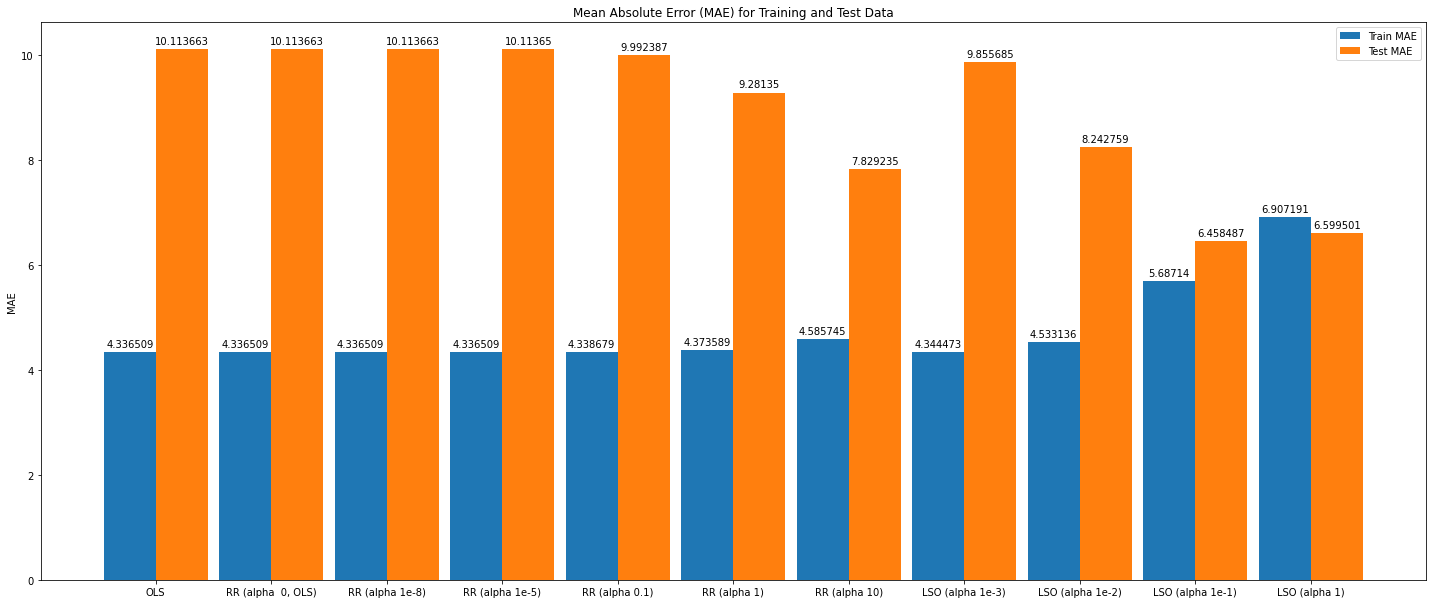

In [191]:
plt.rcParams["figure.figsize"] = [20.00, 8.50]
plt.rcParams["figure.autolayout"] = True
labels = ['OLS', 'RR (alpha  0, OLS)', 'RR (alpha 1e-8)', 'RR (alpha 1e-5)', 'RR (alpha 0.1)', 'RR (alpha 1)', 'RR (alpha 10)',
'LSO (alpha 1e-3)', 'LSO (alpha 1e-2)', 'LSO (alpha 1e-1)', 'LSO (alpha 1)']
mae_train = [train_MAE_OLS, model_alphas_RR[0][0], model_alphas_RR[1][0], model_alphas_RR[2][0], model_alphas_RR[3][0], model_alphas_RR[4][0],
model_alphas_RR[5][0],model_alphas_LSO[0][0], model_alphas_LSO[1][0], model_alphas_LSO[2][0], model_alphas_LSO[3][0]]
mae_train = [round(i,6) for i in mae_train]

mae_test = [test_MAE_OLS, model_alphas_RR[0][1], model_alphas_RR[1][1], model_alphas_RR[2][1], model_alphas_RR[3][1], model_alphas_RR[4][1],
model_alphas_RR[5][1], model_alphas_LSO[0][1], model_alphas_LSO[1][1], model_alphas_LSO[2][1], model_alphas_LSO[3][1]]
mae_test = [round(i,6) for i in mae_test]

x = np.arange(len(labels))
width = 0.45
fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, mae_train, width, label='Train MAE')
rects2 = ax.bar(x + width / 2, mae_test, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_title('Mean Absolute Error (MAE) for Training and Test Data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
   for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), # 3 points vertical offset
         textcoords="offset points",
         ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()


## Visualization: Lasso Model

We can see that the lasso models drop features as the hyperparameter becomes more aggressive. If the lasso model asserts a penalty term that is too high, a sparse matrix can lead to a dubious prediction as too many features were cancelled out by the model; we see this when the hyperameter is 1. 

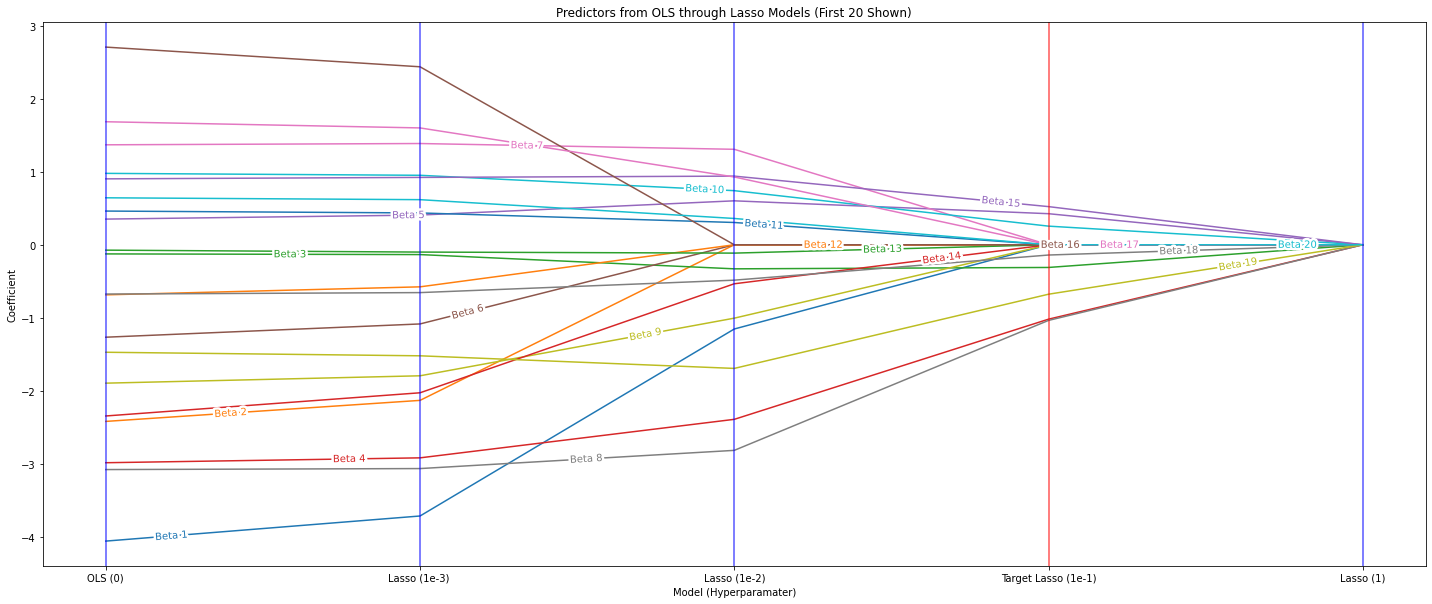

In [192]:

baseline = linear_model.LinearRegression().fit(x_train, Y_train)
prime_model = log_lasso[-2]
labels = ['Beta ' + str(i+1) for i in range(len(prime_model.coef_)-380)]
for i in range(len(prime_model.coef_)-380):
    x1 = 0
    y1 = baseline.coef_[i]

    x2 = 1
    y2 = log_lasso[0].coef_[i]

    x3 = 2
    y3 = log_lasso[1].coef_[i]

    x4 = 3
    y4 = log_lasso[2].coef_[i]

    x5 = 4
    y5 = log_lasso[3].coef_[i]

    x_val = [x1,x2,x3,x4,x5]
    y_val = [y1,y2,y3,y4,y5]

    plt.plot(x_val,y_val, label=labels[i])

#specify x-axis locations
x_ticks = x_val
#specify x-axis labels (lambdas)
x_labels = ['OLS (0)', 'Lasso (1e-3) ', 'Lasso (1e-2)', 'Target Lasso (1e-1)', 'Lasso (1)'] 

#add x-axis values to plot
plt.xticks(ticks=x_ticks, labels=x_labels)

for tick in plt.xticks()[0]: 
    if tick == 3:
        plt.axvline(tick, color='red', linestyle='-', linewidth=2, alpha=.5)
    else:
        plt.axvline(tick, color='blue', linestyle='-', linewidth=2, alpha=.5)


labelLines(plt.gca().get_lines(), zorder=2.5)
plt.ylabel('Coefficient')
plt.xlabel('Model (Hyperparamater)')
plt.title('Predictors from OLS through Lasso Models (First 20 Shown)')
plt.show()